In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

dataset_path = '/content/drive/MyDrive/Colab Notebooks/ECG' # Make sure this is the path you are using

print(f"Listing contents of: {dataset_path}")
try:
    contents = os.listdir(dataset_path)
    print("Contents:")
    for item in contents:
        print(item)
except FileNotFoundError:
    print("Error: The specified dataset path was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Listing contents of: /content/drive/MyDrive/Colab Notebooks/ECG
Contents:
normal
history_mi
mi
abnormal


In [20]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

# Define the base path to your dataset on Google Drive
# IMPORTANT: Replace '/content/drive/My Drive/YourDatasetFolder' with the actual path
dataset_path = '/content/drive/MyDrive/Colab Notebooks/ECG' # <---- MAKE SURE THIS PATH IS CORRECT
print(f"Attempting to access dataset at: {dataset_path}")


# Define the categories based on the actual folder names in the dataset
# Mapping: folder_name -> category_label
category_map = {
    'mi': 'MI',
    'history_mi': 'PMI',
    'abnormal': 'AH'
}
categories = list(category_map.keys()) # Use the folder names for iteration
image_data = []
labels = []
label_names = list(category_map.values()) # Get the standard label names

# Load images and create labels
for category_folder in categories:
    path = os.path.join(dataset_path, category_folder)
    print(f"Checking category path: {path}")
    if not os.path.exists(path):
        print(f"Warning: Category path does not exist: {path}")
        continue # Skip to the next category if the path doesn't exist

    print(f"Loading images from: {path}")
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = Image.open(img_path).convert('RGB') # Ensure image is in RGB format
            img = img.resize((128, 128)) # Resize images to a consistent size
            image_data.append(np.array(img))
            # Assign numerical label based on the mapped category name
            labels.append(label_names.index(category_map[category_folder]))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

image_data = np.array(image_data)
labels = np.array(labels)

# Split data into training and validation sets (e.g., 80% train, 20% validation)
# Check if any data was loaded before splitting
if len(image_data) == 0:
    print("Error: No images were loaded. Please check the dataset path and folder names.")
else:
    X_train, X_val, y_train, y_val = train_test_split(image_data, labels, test_size=0.2, random_state=42, stratify=labels)

    print("Data loaded and split successfully!")
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Validation labels shape: {y_val.shape}")

Attempting to access dataset at: /content/drive/MyDrive/Colab Notebooks/ECG
Checking category path: /content/drive/MyDrive/Colab Notebooks/ECG/mi
Loading images from: /content/drive/MyDrive/Colab Notebooks/ECG/mi
Checking category path: /content/drive/MyDrive/Colab Notebooks/ECG/history_mi
Loading images from: /content/drive/MyDrive/Colab Notebooks/ECG/history_mi
Checking category path: /content/drive/MyDrive/Colab Notebooks/ECG/abnormal
Loading images from: /content/drive/MyDrive/Colab Notebooks/ECG/abnormal
Data loaded and split successfully!
Training data shape: (530, 128, 128, 3)
Validation data shape: (133, 128, 128, 3)
Training labels shape: (530,)
Validation labels shape: (133,)


Now, let's load the dataset from your Google Drive using `ImageDataGenerator`. We'll also set random seeds for reproducibility.

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/Colab Notebooks/ECG'

# Define image dimensions and batch size
img_width, img_height = 128, 128
batch_size = 32

# Use ImageDataGenerator for loading and augmentation
# We'll use a small validation split (e.g., 20%)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load the training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', # Use 'binary' for binary classification if you have two classes
    subset='training')

# Load the validation data
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', # Use 'binary' for binary classification if you have two classes
    subset='validation')

print("Dataset loaded successfully.")
print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
print(f"Found {validation_generator.samples} validation images belonging to {validation_generator.num_classes} classes.")

Found 763 images belonging to 4 classes.
Found 190 images belonging to 4 classes.
Dataset loaded successfully.
Found 763 training images belonging to 4 classes.
Found 190 validation images belonging to 4 classes.


Now, let's test the model with a single image.

Let's change the pre-trained model to MobileNetV2.

In [30]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Load the MobileNetV2 model pre-trained on ImageNet data
# Include_top=False removes the final classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x) # Output layer

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # Use 'binary_crossentropy' for binary classification
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 4,880,068 (18.62 MB)

 Trainable params: 2,622,084 (10.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Now, let's train the model with the frozen MobileNetV2 base layers.

In [31]:
# Train the model with frozen base layers
epochs_frozen = 10  # You can adjust the number of epochs

print(f"Training model with frozen base layers for {epochs_frozen} epochs...")

history_frozen = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_frozen,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

print("\nModel training with frozen base layers complete.")

# Evaluate the model on the validation set after training with frozen layers
loss_frozen, accuracy_frozen = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy (Frozen Layers): {accuracy_frozen*100:.2f}%")
print(f"Validation Loss (Frozen Layers): {loss_frozen:.4f}")

Training model with frozen base layers for 10 epochs...
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3244 - loss: 5.8327 - val_accuracy: 0.3938 - val_loss: 1.3722
Epoch 2/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 16s 728ms/step - accuracy: 0.5000 - loss: 1.3022

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step - accuracy: 0.5000 - loss: 1.3022 - val_accuracy: 0.5188 - val_loss: 1.1200
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6840 - loss: 0.7967 - val_accuracy: 0.7063 - val_loss: 0.6635
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.8125 - loss: 0.4764 - val_accuracy: 0.7125 - val_loss: 0.6825
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.7965 - loss: 0.5097 - val_accuracy: 0.8000 - val_loss: 0.5888
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 497ms/step - accuracy: 0.9062 - loss: 0.3497 - val_accuracy: 0.8125 - val_loss: 0.5691
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8403 - loss: 0.4411 - val_accuracy: 0.8438 - val_loss: 0.4426
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - accuracy: 0.9062 - loss: 0.2728 - val_accuracy: 0.7875 - val_loss: 0.5949
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8812 - loss: 0.3203 - val_accuracy: 0.8562 - val_loss: 

In [50]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the path to your single test image in Google Drive
# IMPORTANT: Replace 'path/to/your/single_image.jpg' with the actual path to your image file
single_image_path = '/content/drive/MyDrive/Colab Notebooks/ECG/normal/Normal(100).jpg' # Example path

# Load and preprocess the image
img = image.load_img(single_image_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Add a batch dimension
img_array /= 255.0  # Rescale the image like the training data

# Make a prediction
predictions = model.predict(img_array)

# Get the predicted class and probability
predicted_class_index = np.argmax(predictions)
predicted_probability = np.max(predictions)

# Get the class labels from the training generator
# This assumes train_generator was created and is available
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

print(f"The model predicts the image belongs to class: {predicted_class_label}")
print(f"Prediction confidence: {predicted_probability*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
The model predicts the image belongs to class: normal
Prediction confidence: 93.51%


In [52]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/Colab Notebooks/ECG/model_2' # Define the path to save your model

In [45]:
# Save the entire model (architecture + weights + optimizer state)
model.save("Model_2.h5")


In [47]:
from tensorflow.keras.models import load_model
model = load_model("Model_2.h5")

In [48]:
model.save('/content/drive/MyDrive/Colab Notebooks/Model_2.h5')


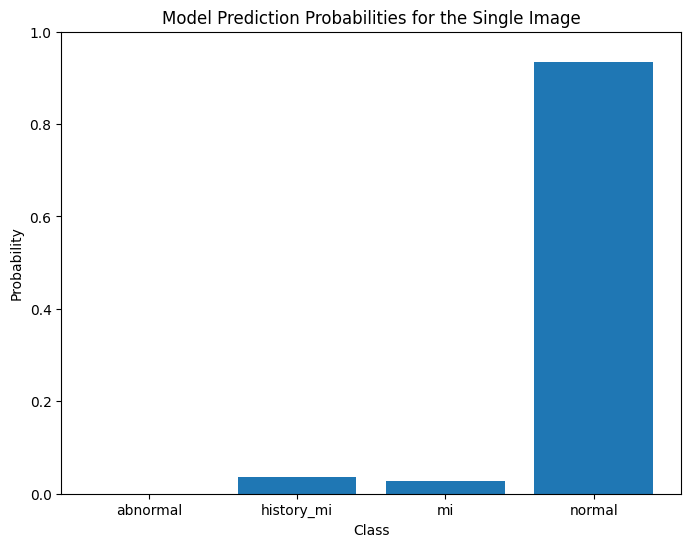

Prediction probabilities per class:
abnormal: 0.0001
history_mi: 0.0367
mi: 0.0281
normal: 0.9351


In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already run the cell to predict on a single image (cell 2fc49fe3)
# and have the 'predictions' and 'class_labels' variables available.

# If not, you can run the single image prediction cell first:
# from tensorflow.keras.preprocessing import image
# # ... (rest of the single image prediction code from cell 2fc49fe3)

# Get the prediction probabilities for the single image
prediction_probabilities = predictions[0]

# Get the class labels from the training generator (assuming train_generator is available)
# If train_generator is not available, you might need to define class_labels manually
# based on your dataset's folder names, e.g., class_labels = ['abnormal', 'history_mi', 'mi', 'normal']
if 'train_generator' in locals():
    class_labels = list(train_generator.class_indices.keys())
else:
     # Assuming the order from your dataset loading output: abnormal, history_mi, mi, normal
     class_labels = ['abnormal', 'history_mi', 'mi', 'normal']


# Create a bar plot of the prediction probabilities
plt.figure(figsize=(8, 6))
plt.bar(class_labels, prediction_probabilities)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title("Model Prediction Probabilities for the Single Image")
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for probabilities
plt.show()

# You can also print the probabilities to see the exact values
print("Prediction probabilities per class:")
for i, prob in enumerate(prediction_probabilities):
    print(f"{class_labels[i]}: {prob:.4f}")